# Full VE problem analysis template

In [1]:
import os
import sys
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#import sympy as sym
import torch

sys.path.append('../src')
import deepymod_torch.VE_datagen as VE_datagen
import deepymod_torch.VE_params as VE_params
from deepymod_torch.DeepMod import DeepMoD
from deepymod_torch.library_function import mech_library

np_seed = 2
torch_seed = 0
np.random.seed(np_seed)
torch.manual_seed(torch_seed)

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

## Data generation

> The below cell is very important for preparing the generation, examination, and saving of the data. It is one of only a few cells that requires configuration in the notebook.

Specify the model parameters

In [2]:
input_type = 'Strain' # Stated up here as it also decides if model is GMM or GKM (strain -> GMM).
if input_type == 'Strain': # model required for calculation of response given manipulation type.
    model = 'GMM'
elif input_type == 'Stress':
    model = 'GKM'

E = 3*[1] # 3*[5e-4]
eta = [0.5, 2.5] # [2.2e-4, 1e-3] # [2.2e-4, 0.5*5e-4/omega]

In [3]:
# # Convert to the equivalent description of model specified above. Final arg should be opposite of this if using.
# E, eta = VE_params.convert_between_models(E, eta, 'GMM')
# print(E, eta)

In [4]:
E_alt = np.array(E[1:])
eta_alt = np.array(eta)
tau = eta_alt/E_alt
tau

array([0.5, 2.5])

Specify the functional form of the input

In [5]:
func_desc = 'Half sinc'

#t = sym.symbols('t', real=True)
#input_expr = sym.sinc(omega*t)

# Wave packets
# omega = 2.5
# amp = 7
# input_expr, d_input_expr, input_torch_lambda = VE_datagen.wave_packet_lambdas_sum(omega, 0.5, 3, amp)

# step
# input_expr = lambda t: 1
# d_input_expr = lambda t: 0
# input_torch_lambda = lambda t: 1 + 0*t

# soft step
def sigmoid_expr(max_value=1, h_shift=1, width=1):
    return lambda t: max_value / (1 + h_shift*np.exp(-t/width))
input_expr = sigmoid_expr(width=0.1)
# derivatives to be defined!
# Affect of multiplying with sinc to be defined!

# sine
# omega = 1
# input_expr = lambda t: np.sin(omega*t)
# d_input_expr = lambda t: omega*np.cos(omega*t)
# input_torch_lambda = lambda t: torch.sin(omega*t)

# sinc
omega = 1
Amp = 7
# def input_expr(t):
#     if t == 0:
#         return 1
#     else:
#         return Amp*np.sin(omega*t)/(omega*t)

# input_expr = lambda t: Amp*np.sin(omega*t)/(omega*t)
input_expr = lambda t: Amp*np.sinc(t*omega/np.pi) # assumed factor of pi needs to be cancelled.
# def d_input_expr(t):
#     if t == 0:
#         return 0
#     else:
#         return (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))

d_input_expr = lambda t: (Amp/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
# No point doing a return 1 line as torch needs a trace between t and 1 which it will not have (derived tensor).
input_torch_lambda = lambda t: Amp*torch.sin(omega*t)/(omega*t)

# sinc with hshift
# omega = 1
# shift = 6*np.pi
# input_expr = lambda t: np.sin(omega*(t - shift))/(omega*(t - shift))
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - shift))/(omega*(t - shift))

# sinc with vshift
# omega = np.pi
# neg_edge = -7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_no_shift = lambda t: np.sin(omega*t)/(omega*t)
# vshift = input_expr_no_shift(neg_edge)
# input_expr = lambda t: input_expr_no_shift(t) - vshift
# d_input_expr = lambda t: (1/t)*(np.cos(omega*t) - np.sin(omega*t)/(omega*t))
# input_torch_lambda = lambda t: torch.sin(omega*t)/(omega*t) - vshift

# sinc with both hshift and vshift
# omega = np.pi
# hshift = 7.5 # for now is 3.75*T where T is 2*pi/omega. The 3.75 is chosen but could be any (n +- 0.25) where n is integer > 0.
# input_expr_h_only = lambda t: np.sin(omega*(t - hshift))/(omega*(t - hshift))
# vshift = input_expr_h_only(0)
# input_expr = lambda t: input_expr_h_only(t) - vshift
# d_input_expr = lambda t: (1/(t - shift))*(np.cos(omega*(t - shift)) - np.sin(omega*(t - shift))/(omega*(t - shift)))
# input_torch_lambda = lambda t: torch.sin(omega*(t - hshift))/(omega*(t - hshift)) - vshift

Specify the independant data points over which to synthesise the data.

In [6]:
time_array = np.linspace(10**-10, 10*np.pi/omega, 5000).reshape(-1, 1)

In [7]:
strain_array, stress_array = VE_datagen.calculate_strain_stress(input_type, time_array, input_expr, E, eta, D_input_lambda=d_input_expr)

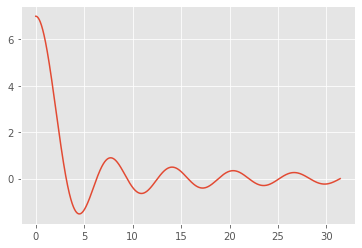

In [8]:
plt.plot(time_array.flatten(), strain_array.flatten(), label='strain')

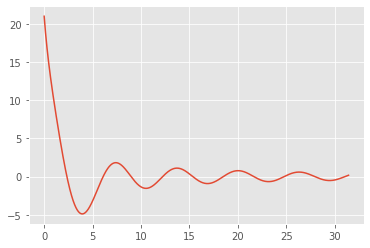

In [9]:
plt.plot(time_array.flatten(), stress_array.flatten(), label='stress')

## Generation Validation

In [10]:
coeffs = VE_params.coeffs_from_model_params(E, eta, model)
errors = VE_datagen.equation_residuals(time_array, strain_array, stress_array, coeffs)

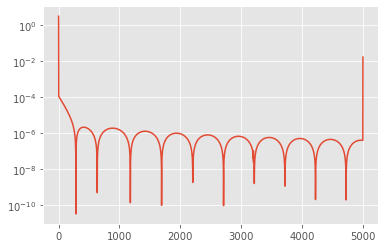

In [11]:
plt.semilogy(abs(errors.flatten()))

## Data Treatment

Presence of t/time_sf in new lambdas is hard to understand but has a reason. The reason is that while unscaled t, stress and strain all map to each other, they need to all map once scaled also. Scaling the time array does not change the target array as these are both precalculated. however, because the analytical input data is calculated based off this NEW SCALED time series in the library function, it is calculated over the scaled time series for the old function, effectively doubling the number of bumps in the curve, rather than stretching it out. we want to calculate the old input_data, ie that originates from the unscaled time data, so we have to unscale the time data on the fly in the library, hence the factor in the lambda function.

This allows PyTorch to map scaled time to scaled input and calculate the appropriate derivatives

Note, this is not an issue for the real data as there is no analytical input term, and the input variable is a dumb target, just like the output variable.

In [12]:
# 'normalising'
time_sf = omega/1.2
strain_sf = 1/np.max(abs(strain_array))
stress_sf = 1/np.max(abs(stress_array))
print(time_sf, strain_sf, stress_sf)

scaled_time_array = time_array*time_sf
if input_type == 'Strain':
    scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: strain_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = stress_array*stress_sf
elif input_type == 'Stress':
    scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)
    scaled_input_torch_lambda = lambda t: stress_sf*input_torch_lambda(t/time_sf)
    scaled_target_array = strain_array*strain_sf

0.8333333333333334 0.14285714285714285 0.047619047619047616


In [13]:
# add noise
noise_level = 0

noisy_target_array = scaled_target_array + noise_level * np.std(scaled_target_array) * np.random.standard_normal(scaled_target_array.shape)

In [14]:
# sampling
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_array.size)

reduced_time_array = scaled_time_array[reordered_row_indices, :][:number_of_samples]
reduced_target_array = noisy_target_array[reordered_row_indices, :][:number_of_samples]

# The below code is a slight alternative version that produces data and targets that are still in chronological order.
# selected_row_indices = reordered_row_indices[:number_of_samples]
# selected_row_indices.sort()
# reduced_time_array = scaled_time_array[selected_row_indices, :]
# reduced_target_array = noisy_target_array[selected_row_indices, :]

## DeepMod prep

In [15]:
time_tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
target_tensor = torch.tensor(reduced_target_array, dtype=torch.float32)

#### Threshold definition

In [16]:
percent = 0.05
thresh_pc = lambda *args: percent

#### Config dictionaries

In [17]:
optim_config = {'lr_coeffs': 0.002, 'thresh_func': thresh_pc, 'mse_only_iterations': 20001}

In [18]:
network_config = {'hidden_dim': 30}

In [19]:
scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
reduced_strain_array = scaled_input_expr(reduced_time_array)

In [20]:
from deepymod_torch.library_function import mech_library_numerical

In [21]:
library_config = {'type': mech_library, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': input_type, 'input_expr': scaled_input_torch_lambda}

## Predicting Coefficients

Predict the true values of the coefficients, based only on the viscoelastic model. These are not necessarily the constants that DeepMoD will find as DeepMoD will only see the scaled data.

In [22]:
not_floats = VE_params.coeffs_from_model_params(E, eta, model)
        
not_floats

[0.166666666666667,
 0.625000000000000,
 0.166666666666667,
 0.500000000000000,
 0.208333333333333]

Scale the true coeffs to what deepmod should find based on the scaling of each term in the equation.

In [23]:
expected_coeffs = VE_params.scaled_coeffs_from_true(not_floats, time_sf, strain_sf, stress_sf)
expected_coeffs

[0.200000000000000,
 0.520833333333333,
 0.600000000000000,
 1.50000000000000,
 0.520833333333333]

## Scaling Validation

In [24]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_input_expr(scaled_time_array), scaled_target_array, expected_coeffs)

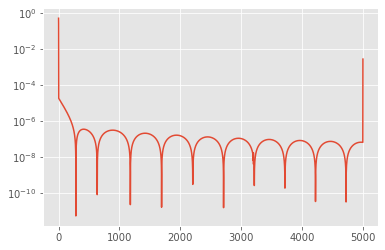

In [25]:
plt.semilogy(abs(errors.flatten()))

## Running DeepMoD

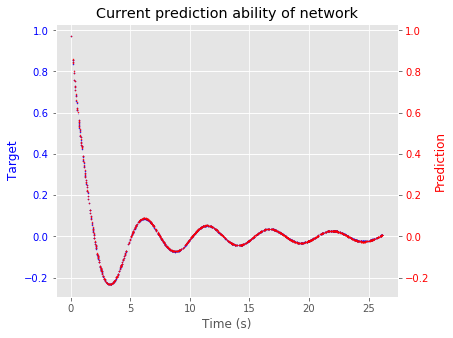

Epoch | Total loss | MSE | PI | L1 | NA
10000 1.2E-06 8.3E-07 3.4E-07 0.0E+00 0.0E+00
tensor([[0.2327],
        [0.5249],
        [0.0319],
        [0.6010],
        [1.4233],
        [0.5033]], requires_grad=True)
Time elapsed: 13.0 minutes 40.13171863555908 seconds


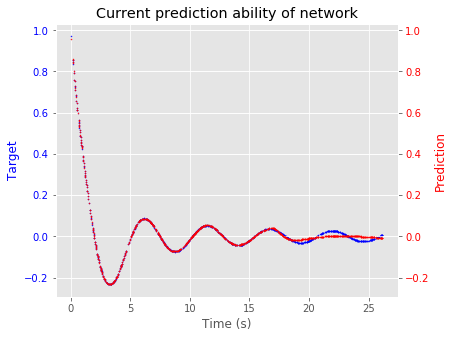

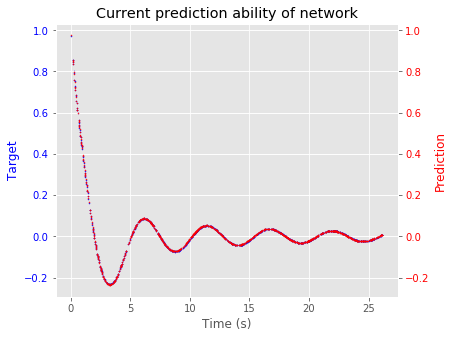

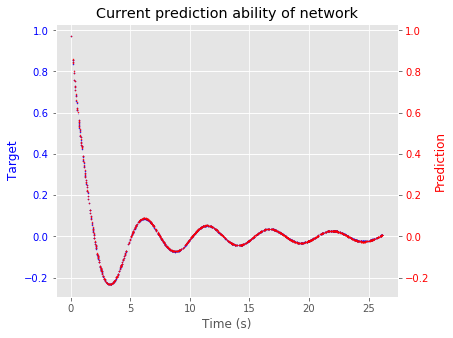

In [26]:
begin_timestamp = datetime.now()
coeff_info_tuple, lstsq_guess_list, network = DeepMoD(time_tensor, target_tensor, library_config, network_config, optim_config, plot=True)
sparse_coeff_vector_list_list, scaled_coeff_vector_list_list, sparsity_mask_list_list = coeff_info_tuple

### Results

In [27]:
lstsq_guess_list

[array([[ 0.71301347],
        [ 0.4133715 ],
        [ 0.55271757],
        [ 0.67403674],
        [ 0.14131443],
        [ 0.03358555],
        [-0.00096161]], dtype=float32)]

In [28]:
sparse_coeff_vector_list_list

[[tensor([[0.2441],
          [0.4277],
          [0.0647],
          [0.6415],
          [1.3227],
          [0.3887],
          [0.0033]], requires_grad=True)], [tensor([[0.2328],
          [0.5249],
          [0.0320],
          [0.6009],
          [1.4234],
          [0.5033]], requires_grad=True)]]

In [29]:
scaled_coeff_vector_list_list

[[tensor([[0.3425],
          [0.3739],
          [0.0583],
          [0.5942],
          [1.3132],
          [0.3584],
          [0.0077]], grad_fn=<MulBackward0>)], [tensor([[0.3267],
          [0.4588],
          [0.0289],
          [0.5572],
          [1.4093],
          [0.4126]], grad_fn=<MulBackward0>)]]

In [30]:
sparsity_mask_list_list

[[tensor([0, 1, 2, 3, 4, 5, 6])], [tensor([0, 1, 2, 3, 4, 5])]]

## Plotting data from coeffs obtained

In [31]:
time_tensor_post = torch.tensor(scaled_time_array, dtype=torch.float32, requires_grad=True)
prediction_tensor = network(time_tensor_post)
prediction_array = np.array(prediction_tensor.detach())
library_diff_order = library_config['diff_order']
if input_type == 'Strain':
    scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
elif input_type == 'Stress':
    scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)

In [32]:
# Run odeint version with numpy arrays, not tensors

# time_tensor_post = scaled_time_array
# prediction_tensor = scaled_target_array
# prediction_array = prediction_tensor
# library_diff_order = library_config['diff_order']
# if input_type == 'Strain':
#     scaled_input_expr = lambda t: strain_sf*input_expr(t/time_sf)
# elif input_type == 'Stress':
#     scaled_input_expr = lambda t: stress_sf*input_expr(t/time_sf)

### Before thresholding

In [33]:
coeff_vector = sparse_coeff_vector_list_list[0][0].clone()
sparsity_mask = sparsity_mask_list_list[0][0].clone()

In [34]:
# Use expected coeffs, not derived ones, tensor version

# coeff_vector = torch.tensor(expected_coeffs[:2] +[0.0001] + expected_coeffs[2:] + [0.0001], dtype=torch.float32, requires_grad=True).reshape(-1, 1)
# coeff_vector

In [35]:
# Use expected coeffs, not derived ones, array version

# coeff_vector = np.array(expected_coeffs[:2] +[0.0001] + expected_coeffs[2:] + [0.0001]).reshape(-1, 1)
# coeff_vector

In [36]:
# Use set of results from a previous run, loading in coeff_vector and sparsity_mask

# rec_results = np.loadtxt('../data/Results/Varying tau for real imitation/param_0-0004056770250488735/final_coeffs_data.csv', delimiter=',')
# coeff_vector = rec_results[:,0:1]
# coeff_vector

In [37]:
# sparsity_mask = rec_results[:,2].astype(int)
# sparsity_mask

In [38]:
# Manually set sparsity_mask

# sparsity_mask = [0,1,2,3,4,5,6]

In [39]:
response_recalc_bt = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor, scaled_input_expr, coeff_vector, sparsity_mask, library_diff_order, input_type)

In [40]:
# Prep for finite difference method

scaled_strain_array = scaled_input_expr(scaled_time_array)
coeff_vector_array = np.array(coeff_vector.detach())
coeff_vector_array

array([[0.24408025],
       [0.42774558],
       [0.06465249],
       [0.6414998 ],
       [1.3227173 ],
       [0.3886795 ],
       [0.00332754]], dtype=float32)

In [41]:
# Alt finite difference method
response_recalc_bt_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, scaled_strain_array, prediction_array, coeff_vector_array, sparsity_mask, library_diff_order, input_type)

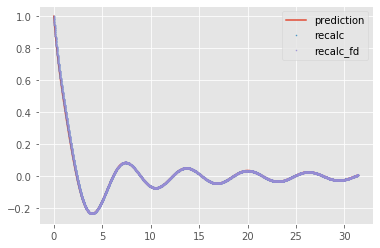

In [42]:
plt.plot(time_array.flatten(), prediction_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_bt.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_bt_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

## Generation Validation

In [43]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, prediction_array, coeff_vector_array, sparsity_mask=sparsity_mask, diff_order=library_diff_order)

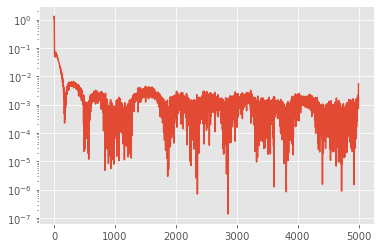

In [44]:
plt.semilogy(abs(errors.flatten()))

### After thresholding

In [45]:
coeff_vector = sparse_coeff_vector_list_list[1][0].clone()
sparsity_mask = sparsity_mask_list_list[1][0].clone()

In [46]:
response_recalc_at = VE_datagen.calculate_int_diff_equation(time_tensor_post, prediction_tensor, scaled_input_expr, coeff_vector, sparsity_mask, library_diff_order, input_type)

In [47]:
# Prep for finite difference method

scaled_strain_array = scaled_input_expr(scaled_time_array)
coeff_vector_array = np.array(coeff_vector.detach())
coeff_vector_array

array([[0.23279983],
       [0.5248794 ],
       [0.03197957],
       [0.6009121 ],
       [1.4234428 ],
       [0.5032767 ]], dtype=float32)

In [48]:
# Alt finite difference method
response_recalc_at_fd = VE_datagen.calculate_finite_difference_diff_equation(scaled_time_array, scaled_strain_array, prediction_array, coeff_vector_array, sparsity_mask, library_diff_order, input_type)

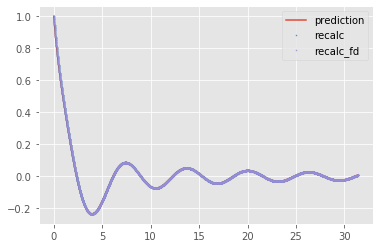

In [49]:
plt.plot(time_array.flatten(), prediction_array.flatten(), label='prediction')
plt.plot(time_array.flatten(), response_recalc_at.flatten(), label='recalc', marker='.', markersize=1, linestyle='None')
plt.plot(time_array.flatten(), response_recalc_at_fd.flatten(), label='recalc_fd', marker='.', markersize=1, linestyle='None')
plt.legend()

## Generation Validation

In [50]:
errors = VE_datagen.equation_residuals(scaled_time_array, scaled_strain_array, prediction_array, coeff_vector_array, sparsity_mask=sparsity_mask, diff_order=library_diff_order)

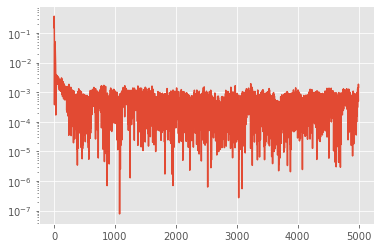

In [51]:
plt.semilogy(abs(errors.flatten()))

## Results Processing

In [52]:
investigated_param = f'Trying standard problem mse ON, NA ON, lambda -5'
param_value = 'NA'
repeat_instance = 0

In [53]:
prediction_array = np.array(network(time_tensor).detach())

if `prediction_coeffs_array` is not equal dimensionally to the `target_coeffs_array`, there would be an error if it weren't for the `if` statement prempting this. In the case where the dimensions don't agree, there is no sensible way to assess these quantities anyway, so this data is mostly abandoned. The coeffs before thresholding are however saved as `pre_thresh_coeffs_array`.

In [54]:
target_coeffs_array = np.array(expected_coeffs).reshape(-1,1)

pre_thresh_coeffs_array = np.array(sparse_coeff_vector_list_list[0][0].detach())
pre_thresh_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[0][0].detach())

final_coeffs_array = np.array(sparse_coeff_vector_list_list[-1][0].detach())
final_scaled_coeffs_array = np.array(scaled_coeff_vector_list_list[-1][0].detach())
sparsity_mask_array = np.array(sparsity_mask_list_list[-1][0]).reshape(-1,1)

if statement just bypasses errors

In [55]:
dg_series_data = np.concatenate((time_array, strain_array, stress_array), axis=1)
NN_series_data = np.concatenate((reduced_time_array, reduced_target_array, prediction_array), axis=1)
pre_thresh_coeffs_data = np.concatenate((pre_thresh_coeffs_array, pre_thresh_scaled_coeffs_array), axis=1)
final_coeffs_data = np.concatenate((final_coeffs_array, final_scaled_coeffs_array, sparsity_mask_array), axis=1)

In [56]:
dt_string = begin_timestamp.strftime('%d/%m/%Y %H:%M:%S')

In [57]:
library_config.pop('strain_array', None)
input_theta = library_config.pop('input_theta')

In [58]:
dg_info_list = [f'E: {E}', f'eta: {eta}', 'Input: '+input_type, 'Desc: '+func_desc, f'omega: {omega}', f'Amp: {Amp}']
dg_info_list

['E: [1, 1, 1]',
 'eta: [0.5, 2.5]',
 'Input: Strain',
 'Desc: Half sinc',
 'omega: 1',
 'Amp: 7']

In [59]:
treatment_info_list = [f'noise_factor: {noise_level}', f'time_sf: {time_sf}', f'strain_sf: {strain_sf}', f'stress_sf: {stress_sf}']
treatment_info_list

['noise_factor: 0',
 'time_sf: 0.8333333333333334',
 'strain_sf: 0.14285714285714285',
 'stress_sf: 0.047619047619047616']

In [60]:
config_dict_list = [f'optim: {optim_config}', f'network: {network_config}', f'library: {library_config}']
config_dict_list

["optim: {'lr_coeffs': 0.002, 'thresh_func': <function <lambda> at 0x7ff324450048>, 'mse_only_iterations': 20001, 'lambda': 1e-05, 'kappa': 1, 'betas_coeffs': (0.9, 0.999), 'max_iterations': 100001, 'final_run_iterations': 10001, 'use_lstsq_approx': False}",
 "network: {'hidden_dim': 30, 'pre-trained_network': None, 'layers': 4}",
 "library: {'type': <function mech_library at 0x7ff3244a1730>, 'diff_order': 3, 'coeff_sign': 'positive', 'input_type': 'Strain', 'input_expr': <function <lambda> at 0x7ff325000400>}"]

In [61]:
misc_list = ['date_stamp: '+dt_string, f'NumPy_seed: {np_seed}', f'Torch_seed: {torch_seed}']
misc_list

['date_stamp: 05/05/2020 11:06:32', 'NumPy_seed: 2', 'Torch_seed: 0']

## Saving

In [62]:
parent_folder = '../data/Results'
first_subfolder = investigated_param.replace('.', '-')
second_subfolder = 'param_' + str(param_value).replace('.', '-')
third_subfolder = 'repeat_' + str(repeat_instance)

foldername = parent_folder + '/' + first_subfolder# + '/' + second_subfolder# + '/' + third_subfolder

In [63]:
if not os.path.isdir(foldername):
    os.makedirs(foldername)

In [64]:
np.savetxt(foldername+'/DG_series_data.csv', dg_series_data, delimiter=',', header='Time, Strain, Stress')
np.savetxt(foldername+'/NN_series_data.csv', NN_series_data, delimiter=',', header='Time, Target, Prediction')
np.savetxt(foldername+'/expected_coeffs.csv', target_coeffs_array, delimiter=',', header='Expected_coeffs')
np.savetxt(foldername+'/pre_thresh_coeffs_data.csv', pre_thresh_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs')
np.savetxt(foldername+'/final_coeffs_data.csv', final_coeffs_data, delimiter=',', header='Trained_Coeffs, Scaled_Trained_Coeffs, Sparsity_Mask')
np.savetxt(foldername+'/final_library.csv', input_theta, delimiter=',')

In [65]:
with open(foldername+'/DG_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in dg_info_list)

In [66]:
with open(foldername+'/treatment_info_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in treatment_info_list)

In [67]:
with open(foldername+'/config_dict_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in config_dict_list)

In [68]:
with open(foldername+'/misc_list.txt', 'w') as file:
    file.writelines("%s\n" % line for line in misc_list)

## Rediscovering mechanical model parameters if possible

We need to take the coefficients that DeepMoD has found and reverse the process in predicting coeffients.

First we do the reverse scaling of the coeffs, this time dividing by the multiplication factor previously found, to scale the scaled coefficients to the true ones.

In [69]:
result = sparse_coeff_vector_list_list[-1][0].clone().detach()
true_coeffs = VE_params.true_coeffs_from_scaled(result, time_sf, strain_sf, stress_sf)
true_coeffs

IndexError: index 3 is out of bounds for axis 0 with size 3

We next use these coefficients to recover our model parameters.

In [ ]:
recovered_mech_params = VE_params.model_params_from_coeffs(true_coeffs, model)
recovered_mech_params

#### Save results if poss

In [ ]:
expected_mech_params_array = np.array(E + eta).reshape(-1,1)
recovered_mech_params_array = np.array(recovered_mech_params).reshape(-1,1)

mech_params =  np.concatenate((expected_mech_params_array, recovered_mech_params_array), axis=1)

np.savetxt(foldername+'/mech_params.csv', mech_params, delimiter=',', header='Expected, Recovered')